<a href="https://colab.research.google.com/github/iCorv/raw_audio_autoencoder/blob/master/raw_audio_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, UpSampling2D, AveragePooling2D, Convolution2DTranspose, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
AUDIO_CHUNK_SIZE = 1024
RATE = 44100

# build the model
input_audio = Input(shape=(1, AUDIO_CHUNK_SIZE, 1))

x = Convolution2D(filters=64, kernel_size=(1,5),activation='relu',padding='same')(input_audio)
x = AveragePooling2D((1,2))(x)
x = Convolution2D(filters=32, kernel_size=(1,5),activation='relu',padding='same')(x)
x = AveragePooling2D((1,2))(x)
x = Convolution2D(filters=4, kernel_size=(1,5), activation='relu',padding='same')(x)
x = AveragePooling2D((1,2))(x)
x = Convolution2D(filters=2, kernel_size=(1,5), activation='relu',padding='same')(x)

# audio chunk encoded in 128 data points
encoded = AveragePooling2D((1,2), name='encoded_audio')(x)

x = Convolution2DTranspose(filters=2, kernel_size=(1,5), activation='relu', padding='same')(encoded)
x = UpSampling2D((1,2))(x)
x = Convolution2DTranspose(filters=4, kernel_size=(1,5), activation='relu', padding='same')(x)
x = UpSampling2D((1,2))(x)
x = Convolution2DTranspose(filters=32, kernel_size=(1,5), activation='relu', padding='same')(x)
x = UpSampling2D((1,2))(x)
x = Convolution2DTranspose(filters=64, kernel_size=(1,5), activation='relu', padding='same')(x)
x = UpSampling2D((1,2))(x)

decoded = Convolution2DTranspose(filters=1, kernel_size=(1,5), activation='linear', padding='same', name='decoded_audio')(x)

autoencoder = Model(input_audio, decoded, name='simple_autoencoder')
autoencoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "simple_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1024, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1024, 64)       384       
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 512, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 512, 32)        10272     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 256, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 256, 4)         644       
_________________________________

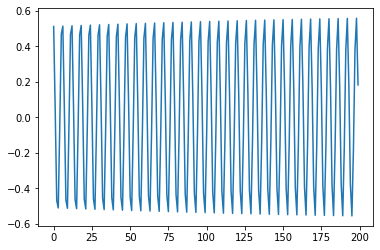

In [3]:
# lets build an audio dataset of random sinus chunks!

# sample rate
fs = RATE
samples = AUDIO_CHUNK_SIZE

# first example
rand_sinus = (np.sin((2*np.pi*np.arange(samples)*440.0/fs) + 0.0)).astype(np.float32)
rand_sinus = np.expand_dims(rand_sinus, axis=1)
rand_sinus = np.expand_dims(rand_sinus, axis=0)
rand_sinus = np.expand_dims(rand_sinus, axis=0)

for idx in range(0, 3300): 
  # random frequency
  f = np.random.randint(30, 8000)
  # random phase shift
  phase = np.random.random() * np.pi
  # random gain
  gain = np.random.uniform(0.5, 1.0)

  sinus = (np.sin((2*np.pi*np.arange(samples)*f/fs) + phase) * gain).astype(np.float32)
  sinus = np.expand_dims(sinus, axis=1)
  sinus = np.expand_dims(sinus, axis=0)
  sinus = np.expand_dims(sinus, axis=0)
  rand_sinus = np.append(rand_sinus, sinus, axis=0)

# split into train and eval dataset
train_dataset = tf.data.Dataset.from_tensor_slices((rand_sinus[:3000], rand_sinus[:3000]))
eval_dataset = tf.data.Dataset.from_tensor_slices((rand_sinus[3000:], rand_sinus[3000:]))

# see if its actually a sinus...
plt.plot(np.squeeze(rand_sinus[11])[:200])

In [4]:
# compile the model with adam optimizer and mean squeared error as its loss function
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

# some constants for training
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

# shuffle and batch the examples
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = eval_dataset.batch(BATCH_SIZE)

# train the model
autoencoder.fit(train_dataset, epochs=100, validation_data=eval_dataset)

Train on 94 steps, validate on 10 steps
Epoch 1/100
94/94 [==============================] - 7s 72ms/step - loss: 0.2661 - mean_squared_error: 0.2661 - val_loss: 0.2570 - val_mean_squared_error: 0.2564
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2441 - mean_squared_error: 0.2440 - val_loss: 0.2358 - val_mean_squared_error: 0.2354
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2218 - mean_squared_error: 0.2219 - val_loss: 0.2200 - val_mean_squared_error: 0.2196
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2096 - mean_squared_error: 0.2096 - val_loss: 0.2101 - val_mean_squared_error: 0.2093
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1978 - mean_squared_error: 0.1978 - val_loss: 0.1998 - val_mean_squared_error: 0.1989
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1858 - mean_squared_error: 0.1859 - val_loss: 0.1875 - val_mean_squared_error: 

In [13]:
# how good is the reconstruction?
sinus = rand_sinus[1100]
sinus = np.expand_dims(sinus, axis=0)
prediction = autoencoder.predict(sinus, batch_size=1)

plt.figure(1)
plt.plot(np.squeeze(sinus)[:200])

plt.figure(2)
plt.plot(np.squeeze(prediction)[:200])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

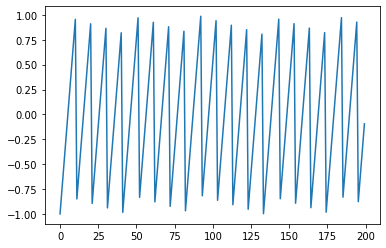

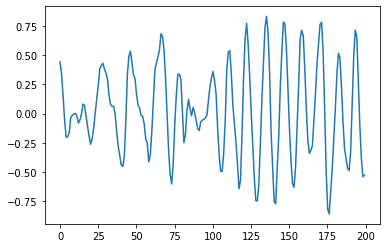

In [11]:
# so what happens if we feed audio into the model which is not a sine wave...

# ...but a sawtooth?
t = np.linspace(0, 1024, 1024)
sawtooth = signal.sawtooth(2 * np.pi * 100 * t)

# plot original signal
plt.figure(3)
plt.plot(t[:200], sawtooth[:200])

sawtooth = np.expand_dims(sawtooth, axis=1)
sawtooth = np.expand_dims(sawtooth, axis=0)
sawtooth = np.expand_dims(sawtooth, axis=0)

# encode and decode the sawtooth
prediction = autoencoder.predict(sawtooth, batch_size=1)

# plot reconstructed signal
plt.figure(4)
plt.plot(t[:200], np.squeeze(prediction)[:200])

In [7]:
# good, the model is not able to interprete a sawtooth properly!
# what does the mse tell us?

mse = ((np.squeeze(prediction) - np.squeeze(sawtooth))**2).mean(axis=0)

print("Mean squared error for reconstructing the sawtooth signal: {:.2f}".format(mse))


Mean squared error for reconstructing the sawtooth signal: 0.48
